
# rompy-xbeach: A Structured Approach to XBeach Modelling Configuration

**A brief tour of rompy-xbeach components**

This notebook demonstrates the key features of rompy-xbeach for configuring
XBeach coastal models using a modern, type-safe Python API.

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import shutil
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

## 1. Grid Definition

Define your model domain with coordinate reference systems and transformations.

Grid: 230 x 220 cells
Domain: 2300m x 3300m
Projection: EPSG:28350


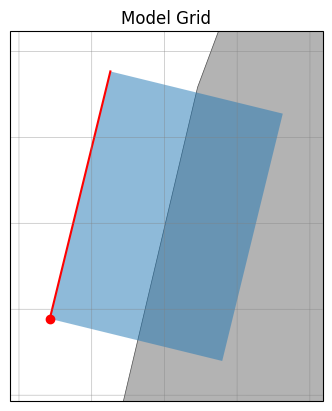

In [3]:
from rompy_xbeach.grid import RegularGrid, GeoPoint

# Define grid in geographic coordinates, project to local UTM
grid = RegularGrid(
    ori=GeoPoint(
        x=115.594239,
        y=-32.641104,
        crs="EPSG:4326"
    ),               # Origin (lon, lat)
    alfa=347.0,      # Grid rotation (degrees from north)
    dx=10.0,         # Cross-shore resolution (m)
    dy=15.0,         # Longshore resolution (m)
    nx=230,          # Cross-shore cells
    ny=220,          # Longshore cells
    crs="EPSG:28350" # Target projection (UTM 50S)
)

print(f"Grid: {grid.nx} x {grid.ny} cells")
print(f"Domain: {grid.nx*grid.dx:.0f}m x {grid.ny*grid.dy:.0f}m")
print(f"Projection: {grid.crs}")

# Visualise
ax = grid.plot(scale="h")
t = plt.title("Model Grid")

## 2. Bathymetry

Load, interpolate, and extend bathymetry onto your grid.

In [15]:
from rompy_xbeach.source import SourceGeotiff
from rompy_xbeach.interpolate import RegularGridInterpolator
from rompy_xbeach.data.base import XBeachBathy, SeawardExtensionLinear

# Assume we have a bathymetry file
DATADIR = Path("../../../rompy-xbeach/tests/data")
bathyfile = DATADIR / "bathy.tif"

# Define bathymetry with automatic seaward extension
bathy = XBeachBathy(
    source=SourceGeotiff(filename=bathyfile),
    interpolator=RegularGridInterpolator(
        kwargs=dict(method="linear", fill_value=None)
    ),
    extension=SeawardExtensionLinear(
        depth=25.0,   # Target offshore depth
        slope=0.1,    # Extension slope
    ),
    posdwn=False,     # Depths are positive up
    left=5,           # Lateral extension (cells)
    right=5,
)

print("✓ Bathymetry configured")
print(f"  Source: {bathyfile.name}")
print(f"  Extension: Linear, <={bathy.extension.slope} slope up to {bathy.extension.depth}m depth")

✓ Bathymetry configured
  Source: bathy.tif
  Extension: Linear, <=0.1 slope up to 25.0m depth


### Plot grid onto bathy to sanity check

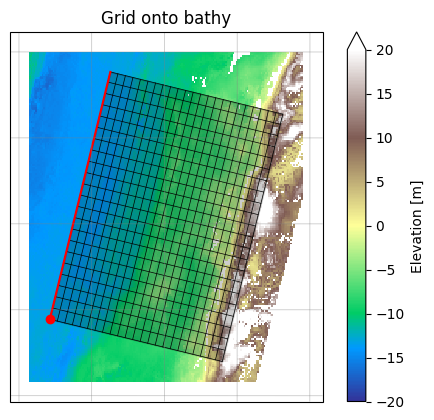

In [22]:
fig, ax = plt.subplots(figsize=None, subplot_kw=dict(projection=grid.projection))
p = bathy.source.open().data.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Elevation [m]")
)
ax = grid.plot(
    ax=ax,
    grid_kwargs=dict(facecolor="k", edgecolor="k", alpha=0.2),
    show_mesh=True,
    mesh_step=10,
)
t = ax.set_title("Grid onto bathy")

## 3. Wave Boundary Conditions

Connect to wave data sources and configure boundary conditions.

In [27]:
from rompy_xbeach.source import SourceCRSWavespectra
from rompy_xbeach.data.boundary import BoundaryStationSpectraSwan

# Load wave spectra from WaveWatch III
wave_source = SourceCRSWavespectra(
    uri=DATADIR / "ww3-spectra-20230101-short.nc",
    reader="read_ww3",
)

# Configure SWAN-type spectral boundary (i.e., will generate SWAN ASCII boundary type)
wave_boundary = BoundaryStationSpectraSwan(
    source=wave_source,
)

print("✓ Wave boundary configured")
print(f"  Type: SWAN spectral")
print(f"  Source: WaveWatch III")

✓ Wave boundary configured
  Type: SWAN spectral
  Source: WaveWatch III


## 4. Physics Configuration

Configure physical processes using component models.

In [51]:
from rompy_xbeach.components.physics import Physics
from rompy_xbeach.components.physics.wavemodel import Surfbeat
from rompy_xbeach.components.physics.friction import Manning

physics = Physics(
    # Wave model: Surfbeat (wave groups + infragravity)
    wavemodel=Surfbeat(),
    
    # Bed friction
    bedfriction=Manning(bedfriccoef=0.02),
    
    # Core processes
    flow=True,        # Flow calculation
    swave=True,       # Short waves
    lwave=True,       # Long waves (infragravity)
    
    # Additional physics
    avalanching=True, # Bed failure on steep slopes
    wci=True,         # Wave-current interaction
    wind=True,        # Include wind in flow solver
)

print("✓ Physics configured")
print(f"  Wave model: {physics.wavemodel.model_type.title()}")
print(f"  Bed friction: {physics.bedfriction.model_type.title()} (n={physics.bedfriction.bedfriccoef})")
print(f"  Processes: flow, long/short waves, wave-current interaction, avalanching, wind")

✓ Physics configured
  Wave model: Surfbeat
  Bed friction: Manning (n=0.02)
  Processes: flow, long/short waves, wave-current interaction, avalanching, wind


## 5. Sediment & Morphology

Configure sediment transport and morphological evolution.

In [33]:
from rompy_xbeach.components.sediment import Sediment
from rompy_xbeach.components.sediment.morphology import Morphology
from rompy_xbeach.components.sediment.transport import SedimentTransport

sediment = Sediment(
    # Morphology with acceleration
    morphology=Morphology(
        morfac=10.0,      # 10x morphological acceleration
        morstart=3600.0,  # Start after 1 hour (spin-up)
        morstop=43200.0,  # Stop at 12 hours
    ),
    
    # Sediment transport
    sedtrans=SedimentTransport(
        form="vanthiel_vanrijn",        # Transport formulation
        bdslpeffmag="roelvink_total",   # Bed slope effects
        facua=0.15,                      # Wave asymmetry factor
    ),
)

print("✓ Sediment configured")
print(f"  Morfac: {sediment.morphology.morfac:0.0f}x acceleration")
print(f"  Active: 1-{sediment.morphology.morstop/3600:0.0f} hours")
print(f"  Formulation: {sediment.sedtrans.form}")

✓ Sediment configured
  Morfac: 10x acceleration
  Active: 1-12 hours
  Formulation: vanthiel_vanrijn


## 6. Output Configuration

Define what variables to output, where and when.

In [38]:
from rompy_xbeach.components.output import Output

output = Output(
    outputformat="netcdf",

    # Global output (full 2D instantaneous fields)
    tintg=3600.0,  # Output every hour
    
    # Variables to output, these are validated
    globalvars=[
        "hh",      # Water depth
        "zs",      # Water level
        "zb",      # Bed level
        "H",       # Wave height
        "ue",      # Velocity (x)
        "ve",      # Velocity (y)
        "urms",    # RMS velocity
    ],
)

print("✓ Output configured")
print(f"  Format: {output.outputformat}")
print(f"  Interval: {output.tintg / 3600}h")
print(f"  Variables: {[v.value for v in output.globalvars]}")

✓ Output configured
  Format: netcdf
  Interval: 1.0h
  Variables: ['hh', 'zs', 'zb', 'H', 'ue', 've', 'urms']


## 7. Complete Configuration

Assemble all components into a complete XBeach configuration.

In [42]:
from rompy_xbeach.config import Config, DataInterface

config = Config(
    # Spatial domain
    grid=grid,

    # Bathymetry
    bathy=bathy,
    
    # Boundary conditions
    input=DataInterface(wave=wave_boundary),
    
    # Physical processes
    physics=physics,
    
    # Sediment & morphology
    sediment=sediment,
    
    # Output
    output=output,
    
    # Boundary types (needs to be moved into components)
    front="abs_2d",      # Offshore: weakly reflective
    back="abs_2d",       # Onshore: weakly reflective
    left="neumann",      # Lateral: no gradient
    right="neumann",
    lateralwave="wavecrest",  # Wave crests perpendicular to boundary
)

print("✓ Complete configuration assembled")
print(f"  Components: grid, bathy, wave, physics, sediment, output")

✓ Complete configuration assembled
  Components: grid, bathy, wave, physics, sediment, output


## 8. Generate Model Files

Create all XBeach input files in one step.

In [52]:
from rompy.core.time import TimeRange
from rompy.model import ModelRun

# Define simulation time
times = TimeRange(
    start="2023-01-01T00:00",
    end="2023-01-01T12:00",  # 12-hour simulation
    freq="1h"
)

# Create workspace directory
output_dir = Path("./demo_output")
if output_dir.exists():
    shutil.rmtree(output_dir)
output_dir.mkdir()

print(f"Generating model files in: {output_dir}")
print(f"Simulation: {times.start} to {times.end}")

# Generate all input files
modelrun = ModelRun(
    run_id="test1",
    period=times,
    output_dir=output_dir,
    config=config,
)
modelrun.generate()

2025-11-26 14:25:35 [INFO] rompy.model         : ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
2025-11-26 14:25:35 [INFO] rompy.model         : ┃                      MODEL RUN CONFIGURATION                       ┃
2025-11-26 14:25:35 [INFO] rompy.model         : ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
2025-11-26 14:25:35 [INFO] rompy.model         :             Run ID : test1
2025-11-26 14:25:35 [INFO] rompy.model         :         Model Type : Config
2025-11-26 14:25:35 [INFO] rompy.model         :         Start Time : 2023-01-01T00:00:00
2025-11-26 14:25:35 [INFO] rompy.model         :           End Time : 2023-01-01T12:00:00
2025-11-26 14:25:35 [INFO] rompy.model         :           Duration : 12 hours
2025-11-26 14:25:35 [INFO] rompy.model         :      Time Interval : 1:00:00
2025-11-26 14:25:35 [INFO] rompy.model         :   Output Directory : demo_output
2025-11-26 14:25:35 [INFO] rompy.model         : ┏━━━━━━━━━━━━━━━━━━

Generating model files in: demo_output
Simulation: 2023-01-01 00:00:00 to 2023-01-01 12:00:00


2025-11-26 14:25:36 [INFO] rompy.model         : Rendering model templates to demo_output/test1...
2025-11-26 14:25:36 [INFO] rompy.core.render   : Template source: /source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base
2025-11-26 14:25:36 [INFO] rompy.core.render   : Output directory: demo_output
2025-11-26 14:25:36 [INFO] rompy.core.render   : Using template version: main
2025-11-26 14:25:36 [INFO] rompy.core.render   :   • Locating template repository...
2025-11-26 14:25:36 [INFO] rompy.core.render   : Template repository located at: /source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base
2025-11-26 14:25:36 [INFO] rompy.core.render   :   • Generating files from template...
2025-11-26 14:25:36 [INFO] rompy.core.render   :   • Rendering time:      0.00 seconds
2025-11-26 14:25:36 [INFO] rompy.core.render   :   • Total process time:  0.00 seconds
2025-11-26 14:25:36 [INFO] rompy.core.render   :   • Files created:       9
2025-11-26 14:25:36 [INFO] rompy.core.render   :   • Outp

'/source/csiro/rompy-notebooks/notebooks/xbeach/demo_output/test1'

## 9. Key Features Summary

### Component Architecture
- **Physics**: Wave models, friction, processes
- **Sediment**: Transport, morphology, avalanching
- **Output**: Variables, timing, format
- **Boundary**: Waves, wind, tide

### Data Integration
- **Sources**: GeoTIFF, NetCDF, CSV, WaveWatch III, SWAN
- **Interpolation**: Automatic grid interpolation
- **Extension**: Seaward and lateral domain extension

### Type Safety
- **Validation**: Pydantic models catch errors early
- **Discriminated unions**: Type-safe component selection
- **IDE support**: Autocomplete and type hints

### Flexibility
- **Procedural**: Python API (this notebook)
- **Declarative**: YAML configuration files
- **Hybrid**: Mix both approaches

## 10. Quick Examples

### Example 1: Hydrodynamics Only

In [ ]:
config_hydro = Config(
    grid=grid,
    bathy=bathy,
    input=dict(wave=wave_boundary),
    physics=Physics(
        wavemodel=Surfbeat(),
        bedfriction=Manning(bedfriccoef=0.02),
    ),
    sediment=Sediment(
        morphology=False,  # No morphology
        sedtrans=False,    # No sediment transport
    ),
    output=output,
    front="abs_2d",
    back="abs_2d",
)

print("Example 1: Hydrodynamics only (no morphology)")

### Example 2: Storm Impact with Morphology

In [ ]:
config_storm = Config(
    grid=grid,
    bathy=bathy,
    input=dict(wave=wave_boundary),
    physics=Physics(
        wavemodel=Surfbeat(),
        bedfriction=Manning(bedfriccoef=0.02),
        avalanching=True,
    ),
    sediment=Sediment(
        morphology=Morphology(morfac=5.0),  # 5x acceleration
        sedtrans=SedimentTransport(form="vanthiel_vanrijn"),
    ),
    output=output,
    front="abs_2d",
    back="abs_2d",
)

print("Example 2: Storm impact with morphology (morfac=5)")

### Example 3: Nature-Based Solutions

In [ ]:
config_nbs = Config(
    grid=grid,
    bathy=bathy,
    input=dict(wave=wave_boundary),
    physics=Physics(
        wavemodel=Surfbeat(),
        bedfriction=Manning(bedfriccoef=0.02),
        vegetation=True,  # Wave-vegetation interaction
    ),
    sediment=Sediment(
        morphology=Morphology(morfac=10.0),
        sedtrans=SedimentTransport(form="vanthiel_vanrijn"),
    ),
    output=output,
    front="abs_2d",
    back="abs_2d",
)

print("Example 3: Nature-based solutions (vegetation)")

## 11. Parameter Coverage

**rompy-xbeach implements 223 out of 297 XBeach parameters (75% coverage)**

### Fully Implemented:
- ✅ All wave models (Surfbeat, Stationary, Non-hydrostatic)
- ✅ All friction formulations (Manning, Chezy, White-Colebrook, etc.)
- ✅ Sediment transport formulations
- ✅ Morphology and avalanching
- ✅ Wave boundary conditions (JONSWAP, SWAN, etc.)
- ✅ Output configuration
- ✅ Grid and bathymetry

### Not Yet Implemented:
- ⏳ Hotstart (restart files)
- ⏳ Rainfall
- ⏳ Discharge sources
- ⏳ Drifter tracking

**The core functionality for coastal modeling is complete!**

## 12. Comparison with Traditional XBeach

### Traditional params.txt:
```
wavemodel = surfbeat
bedfriction = manning
bedfriccoef = 0.02
morfac = 10
morphology = 1
sedtrans = 1
form = vanthiel_vanrijn
...
```

### rompy-xbeach:
```python
config = Config(
    physics=Physics(
        wavemodel=Surfbeat(),
        bedfriction=Manning(bedfriccoef=0.02),
    ),
    sediment=Sediment(
        morphology=Morphology(morfac=10.0),
        sedtrans=SedimentTransport(form="vanthiel_vanrijn"),
    ),
)
```

### Benefits:
- ✅ **Type safety**: Catch errors before running
- ✅ **Validation**: Invalid parameter combinations rejected
- ✅ **Documentation**: Inline help and examples
- ✅ **Reusability**: Component-based, DRY principle
- ✅ **Version control**: Python/YAML in git
- ✅ **Integration**: Part of larger workflows

## 13. Next Steps

### Documentation
- **Examples**: `/examples/` directory
  - `physics_demo.py` - Physics configuration
  - `sediment_demo.py` - Morphology configuration
  - `wave_boundary_conditions_tutorial.py` - Boundary conditions

### Resources
- **GitHub**: [rompy-xbeach repository]
- **XBeach Manual**: https://xbeach.readthedocs.io
- **rompy**: Parent framework for coastal model orchestration

### Getting Started
```bash
pip install rompy-xbeach
```

### Questions?
- Issues on GitHub


---

# Thank You!
---
